In [1]:
import numpy as np
import os
import time
import matplotlib.pylab as plt
from  torch.utils.data import Dataset
from torchvision import datasets, transforms
import sys
import random
import math
import warnings
import pandas as pd

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def data_preprocessing_torch(signals): # 하나의 데이터셋에 대한 data_preprocessing (using torch)
    signals = (signals - signals.mean(dim=1).unsqueeze(1))/signals.std(dim=1).unsqueeze(1)

    return signals

def data_preprocessing_oneToOne_torch(signals,min,max,max_value):
    signals_std = (signals + max_value) / (2*max_value)
    signals_scaled = signals_std * (max - min) + min
    return signals_scaled

def data_preprocessing_minmax_torch(signals,min,max):
    signals_std = (signals - signals.min(dim=1).unsqueeze(1)) / (
            signals.max(dim=1).unsqueeze(1) - signals.min(dim=1).unsqueeze(1))
    signals_scaled = signals_std * (max - min) + min
    return signals_scaled

def get_dataset_one_channel_norm_withoutCut(dirname,annotations_dir,data_path,use_noise=True,epsilon=0.5,noise_scale=2e-6,preprocessing=True,norm_methods='Standard'):
    # npy read!
    path = dirname + data_path
    signals = np.load(path)

    signals = torch.from_numpy(signals).float().to(device)

    if use_noise:
        if np.random.rand() < epsilon:
            # noise = np.random.normal(loc=0,scale=noise_scale,size=signals.shape)
            # signals = signals + noise
            noise = torch.normal(mean=0., std=noise_scale, size=signals.shape).to(device)
            signals = signals + noise

    if preprocessing:
        if norm_methods == 'Standard':
            signals = data_preprocessing_torch(signals)
        elif norm_methods == 'minmax':
            signals = data_preprocessing_minmax_torch(signals,0,1)
        elif norm_methods == 'oneToOne':
            signals = data_preprocessing_oneToOne_torch(signals,-1,1,1e-4)
    label = get_annotations(annotations_dir, data_path)
    return signals, label

# model conv layer weight init function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:         # Conv weight init
        torch.nn.init.xavier_uniform_(m.weight.data)
        
def suffle_dataset_list(dataset_list): # 데이터 셔플
    random.shuffle(dataset_list)
    return dataset_list


# npy파일을 통해 label을 가져오는 함수
def get_annotations(label_dir,file_name):
    label_path = label_dir + file_name
    label = np.load(label_path)
    return label

def signals_expand_torch_one_channel(signals): # 2차원 데이터를 3차원으로 변환 (8,N) -> (batch,8,6000) 형태로
    signals = signals.expand(1,1,-1)
    #print(signals.shape)
    signals = signals.transpose(2, 1) # 차원 변경
    signals = signals.reshape(-1, 3000, 1) # 형태 변환
    signals = signals.transpose(2, 1) # 차원 변경
    return signals

In [3]:

class DeepSleepNet_Classification(nn.Module):  # input channel = 8channel / output = 5
    def __init__(self,in_channel=1,out_channel=6,layer=[64,128,128,128],sample_rate = 100):
        super(DeepSleepNet_Classification, self).__init__()

        self.conv1_1d_big = nn.Conv1d(in_channels=in_channel, out_channels=layer[0], kernel_size=sample_rate*4, stride=sample_rate//2,
                                      padding=sample_rate*4//2,
                                      bias=False)
        self.conv2_1d_big = nn.Conv1d(in_channels=layer[0], out_channels=layer[1], kernel_size=6, stride=1, padding=3,
                                      bias=False)
        self.conv3_1d_big_1 = nn.Conv1d(in_channels=layer[1], out_channels=layer[2], kernel_size=6, stride=1, padding=3,
                                        bias=False)
        self.conv3_1d_big_2 = nn.Conv1d(in_channels=layer[2], out_channels=layer[3], kernel_size=6, stride=1, padding=3,
                                        bias=False)
        self.maxpool1_big = nn.MaxPool1d(kernel_size=4, stride=4, padding=2)
        self.maxpool2_big = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)

        self.conv1_1d_small = nn.Conv1d(in_channels=in_channel, out_channels=layer[0], kernel_size=sample_rate//2, stride=sample_rate//16,
                                        padding=sample_rate//2//2,
                                        bias=False)
        self.conv2_1d_small = nn.Conv1d(in_channels=layer[0], out_channels=layer[1], kernel_size=8, stride=1, padding=4,
                                        bias=False)
        self.conv3_1d_small_1 = nn.Conv1d(in_channels=layer[1], out_channels=layer[2], kernel_size=8, stride=1,
                                          padding=4,
                                          bias=False)
        self.conv3_1d_small_2 = nn.Conv1d(in_channels=layer[2], out_channels=layer[3], kernel_size=8, stride=1,
                                          padding=4,
                                          bias=False)
        self.maxpool1_small = nn.MaxPool1d(kernel_size=8, stride=8, padding=4)
        self.maxpool2_small = nn.MaxPool1d(kernel_size=4, stride=4, padding=2)

        self.ReLU = nn.ReLU()

        self.batch_norm_small_1 = nn.BatchNorm1d(64)
        self.batch_norm_small_2 = nn.BatchNorm1d(128)
        self.batch_norm_small_3 = nn.BatchNorm1d(128)
        self.batch_norm_small_4 = nn.BatchNorm1d(128)

        self.batch_norm_big_1 = nn.BatchNorm1d(64)
        self.batch_norm_big_2 = nn.BatchNorm1d(128)
        self.batch_norm_big_3 = nn.BatchNorm1d(128)
        self.batch_norm_big_4 = nn.BatchNorm1d(128)

        self.dropout_big = nn.Dropout(p=0.5)
        self.dropout_small = nn.Dropout(p=0.5)

        self.fc = nn.Linear(1280 + 2176, out_channel)  # big and small conv concat
        #self.fc2 = nn.Linear(1000, 5)  # big and small conv concat\
        # Dense 부분에서도 Bias없이 해볼 것!
        # self.fc = nn.Linear(384+8250,5,bias=False)

    def forward(self, input):
        # print("feature_extract_2d.shape : ", feature_extract_2d.shape)
        # 여기서 문제 발생 weight의 경우에는 [64 , 32 , 100] 이지만 input 이 2차원 [32, 750]이라 문제 발생!
        feature_big = self.conv1_1d_big(input)
        feature_big = self.batch_norm_big_1(feature_big)
        feature_big = self.ReLU(feature_big)

        feature_big = self.maxpool1_big(feature_big)

        feature_big = self.dropout_big(feature_big)

        feature_big = self.conv2_1d_big(feature_big)
        feature_big = self.batch_norm_big_2(feature_big)
        feature_big = self.ReLU(feature_big)

        feature_big = self.conv3_1d_big_1(feature_big)
        feature_big = self.batch_norm_big_3(feature_big)
        feature_big = self.ReLU(feature_big)

        feature_big = self.conv3_1d_big_2(feature_big)
        feature_big = self.batch_norm_big_4(feature_big)
        feature_big = self.ReLU(feature_big)

        feature_big = self.maxpool2_big(feature_big)

        feature_small = self.conv1_1d_small(input)
        feature_small = self.batch_norm_small_1(feature_small)
        feature_small = self.ReLU(feature_small)

        feature_small = self.maxpool1_small(feature_small)
        feature_small = self.dropout_small(feature_small)

        feature_small = self.conv2_1d_small(feature_small)
        feature_small = self.batch_norm_small_2(feature_small)
        feature_small = self.ReLU(feature_small)

        feature_small = self.conv3_1d_small_1(feature_small)
        feature_small = self.batch_norm_small_3(feature_small)
        feature_small = self.ReLU(feature_small)

        feature_small = self.conv3_1d_small_2(feature_small)
        feature_small = self.batch_norm_small_4(feature_small)
        feature_small = self.ReLU(feature_small)

        feature_small = self.maxpool2_small(feature_small)

        feature_big = torch.flatten(feature_big, 1)

        feature_small = torch.flatten(feature_small, 1)  # (batch, channel)

        output = torch.cat((feature_big, feature_small), dim=1)
        output = self.fc(output)

        return output


In [4]:
model = DeepSleepNet_Classification()
summary(model.cuda(),(1,3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 61]          25,600
       BatchNorm1d-2               [-1, 64, 61]             128
              ReLU-3               [-1, 64, 61]               0
         MaxPool1d-4               [-1, 64, 16]               0
           Dropout-5               [-1, 64, 16]               0
            Conv1d-6              [-1, 128, 17]          49,152
       BatchNorm1d-7              [-1, 128, 17]             256
              ReLU-8              [-1, 128, 17]               0
            Conv1d-9              [-1, 128, 18]          98,304
      BatchNorm1d-10              [-1, 128, 18]             256
             ReLU-11              [-1, 128, 18]               0
           Conv1d-12              [-1, 128, 19]          98,304
      BatchNorm1d-13              [-1, 128, 19]             256
             ReLU-14              [-1, 

In [5]:
def search_npy_list(dirname):  # 매개변수 dir에서 모든 npy파일을 찾고 fold에 따른 dataset 나누기
    filenames = os.listdir(dirname)
    filenames = [file for _, file in enumerate(filenames) if file.endswith(".npy")]
    return filenames

In [6]:

def CB_focal_loss(labels, logits, alpha, gamma):

    BCLoss = F.binary_cross_entropy_with_logits(input = logits, target = labels,reduction = "none")

    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 +
            torch.exp(-1.0 * logits)))

    loss = modulator * BCLoss

    weighted_loss = alpha * loss
    focal_loss = torch.sum(weighted_loss)

    focal_loss /= torch.sum(labels)
    return focal_loss


# saples_per_cls = 샘플의 비율
# no_of_classes = 클래스의 수
#
class CB_loss(nn.Module):
    def __init__(self,samples_per_cls, no_of_classes, loss_type, beta=0.9999, gamma=2.0):
        super(CB_loss,self).__init__()
        self.samples_per_cls = samples_per_cls
        self.no_of_classes = no_of_classes
        self.loss_type = loss_type
        self.beta = beta
        self.gamma = gamma

        self.effective_num = 1.0 - np.power(self.beta, self.samples_per_cls)
        #print(effective_num)
        self.weights = (1.0 - self.beta) / np.array(self.effective_num)
        #print(weights)
        self.weights = self.weights / np.sum(self.weights) * self.no_of_classes
        self.weights = torch.tensor(self.weights).float()
        self.weights = self.weights.to(device)

    def forward(self,logits,labels):

        #print(weights)
        #print(weights.shape)
        labels_one_hot = F.one_hot(labels, self.no_of_classes).float() # one-hot Encoding

        #print('weight to Float',weights)
        weights = self.weights.unsqueeze(0)# (5) -> (1,5) [1,1,1,1,1]->[[1,1,1,1,]]
        #print('weight unqueeze ',weights)
        #print('weight repeat without dot',weights.repeat(labels_one_hot.shape[0],1))
        weights = weights.repeat(labels_one_hot.shape[0],1) * labels_one_hot # label에 해당하는 위치의 weight값
        #
        #print('weights repeat ',weights)
        weights = weights.sum(1)

        #print('weight sum',weights)
        weights = weights.unsqueeze(1)
        #print('weight un squeeze',weights)
        weights = weights.repeat(1,self.no_of_classes) # 정답 class의 weight로 해당 batch의 모든 class weight 일치시킴
        #print('weight repeat',weights)

        if self.loss_type == "focal":
            cb_loss = CB_focal_loss(labels_one_hot, logits, weights, self.gamma)
        elif self.loss_type == "sigmoid":
            cb_loss = F.binary_cross_entropy_with_logits(input = logits,target = labels_one_hot, weight = weights)
        elif self.loss_type == "softmax":
            pred = logits.softmax(dim = 1)
            cb_loss = F.binary_cross_entropy(input = pred, target = labels_one_hot, weight = weights)
        return cb_loss


In [7]:
def train_model_withNoise_norm(save_filename,logging_filename,train_signal_dir, test_signal_dir,annotations_dir
                               ,epochs=2000,learning_rate=0.001,step_size=100,gamma=0.5,channel=0,
                               layer_filters=[64,128,256,512],first_conv=[200,40,100],optim='Adam',lf='CE',
                               epsilon=0.7,noise_scale=2e-6,min_value=-1e-4,max_value=1e-4,preprocessing=True,
                               norm_methods='Standard',use_noise=True,loss_type='softmax'):
    # Adam optimizer param
    b1 = 0.5
    b2 = 0.999

    beta = 0.001

    check_file = open(logging_filename, 'w')  # logging file

    print('Preproceesing  : ',preprocessing)
    print('min/max value : %f/%f'%(min_value,max_value))
    print('noise scale : ',noise_scale)
    print('loss function : ',lf)
    print('epsilon : ',epsilon)
    print('norm methods : ',norm_methods)

    print('logging file name : ', logging_filename)
    print('save file name : ', save_filename)
    print('layer filters : ',layer_filters)
    print('fisrt_conv info : ',first_conv)
    print('loss type : ',loss_type)
    print('training data oversampling noise : ',use_noise)
    best_accuracy = 0.
    best_epoch = 0

    train_dataset_list = search_npy_list(train_signal_dir)
    test_dataset_list = search_npy_list(test_signal_dir)

    train_dataset_len = len(train_dataset_list)
    test_dataset_len = len(test_dataset_list)

    print('train_dataset length : ', len(train_dataset_list))
    print(train_dataset_list)

    print('test_dataset length : ',test_dataset_len)
    print(test_dataset_list)


    model = DeepSleepNet_Classification()

    #model = resnet18_200hz(in_channel=1,layer_filters=layer_filters,first_conv=first_conv,use_batchnorm=True,num_classes=5)

    model.apply(weights_init) # weight init

    cuda = torch.cuda.is_available()

    if cuda:
        print('can use CUDA!!!')
        model = model.cuda()
    #summary(model,[1,6000])
    print('torch.cuda.device_count() : ', torch.cuda.device_count())
    if torch.cuda.device_count() > 1:
        print('Multi GPU Activation !!!')
        #model = nn.DataParallel(model)

    # loss funcition
    if lf == 'CE':
        loss_fn = nn.CrossEntropyLoss().to(device)
    elif lf == 'CEW':
        samples_per_cls = [27,15,41,5,11]
        no_of_classes = 5
        effective_num = 1.0 - np.power(beta,samples_per_cls)
        #print(effective_num)
        weights = (1.0 - beta) / np.array(effective_num)
        #print(weights)
        weights = weights / np.sum(weights) * no_of_classes
        weights = torch.tensor(weights).float()
        weights = weights.to(device)
        loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)
    elif lf == 'FL':
        loss_fn = FocalLoss(gamma=2).to(device)
    elif lf == 'CBL':
        loss_fn = CB_loss(samples_per_cls=[27,15,41,5,11],no_of_classes=5,loss_type=loss_type,beta=0.9999,gamma=2.0)
    #loss_fn = FocalLoss(gamma=2).to(device)

    # optimizer ADAM (SGD의 경우에는 정상적으로 학습이 진행되지 않았음)
    if optim == 'Adam':
        print('Optimizer : Adam')
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(b1, b2))
    elif optim == 'RMS':
        print('Optimizer : RMSprop')
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optim == 'SGD':
        print('Optimizer : SGD')
        optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=gamma, patience=10,
                                                           min_lr=1e-6)
    #stride = 40 일 때, batch_size = 20이면 16GB정도의 메모리 사용
    batch_size = 5
    norm_square = 2

    train_batch_size = math.ceil(train_dataset_len / batch_size)
    print('train_batch_size : ',train_batch_size)

    test_batch_size = test_dataset_len

    best_accuracy = 0.
    stop_count = 0
    for epoch in range(epochs):
        train_dataset = suffle_dataset_list(train_dataset_list) # 매 epoch마다 train_dataset shuffle !
        count = 0  # check batch
        train_total_loss = 0.0
        train_total_count = 0
        train_total_data = 0

        val_total_loss = 0.0
        val_total_count = 0
        val_total_data = 0

        test_total_loss = 0.0
        test_total_count = 0
        test_total_data = 0

        start_time = time.time()
        model.train()

        output_str = 'current_lr : %f\n'%(optimizer.state_dict()['param_groups'][0]['lr'])
        sys.stdout.write(output_str)
        check_file.write(output_str)
        for index, file_name in enumerate(train_dataset):
            #print('index : ',index)
            if index % batch_size == 0:
                batch_signal, batch_label = get_dataset_one_channel_norm_withoutCut(train_signal_dir,annotations_dir,file_name,
                                                                         use_noise=use_noise,epsilon=epsilon,noise_scale=noise_scale,
                                                                         preprocessing=preprocessing,norm_methods=norm_methods)
            else:
                new_signal, new_label = get_dataset_one_channel_norm_withoutCut(train_signal_dir,annotations_dir,file_name,
                                                                         use_noise=use_noise,epsilon=epsilon,noise_scale=noise_scale,
                                                                         preprocessing=preprocessing,norm_methods=norm_methods)

                batch_signal = torch.cat((batch_signal, new_signal),dim=1)
                batch_label = np.concatenate((batch_label, new_label))
            count += 1
            if count == batch_size or index == len(train_dataset) - 1:  # batch 학습 시작!
                batch_signal = signals_expand_torch_one_channel(batch_signal)
                #batch_signal = signals_expand_torch_one_channel(batch_signal)
                # batch_signal = torch.from_numpy(batch_signal).float().to(device)
                batch_label = torch.from_numpy(batch_label).long().to(device)
                optimizer.zero_grad()
                # print(batch_signal.shape)
                # print(batch_signal)
                pred = model(batch_signal)
                norm = 0

                for parameter in model.parameters():
                    norm += torch.norm(parameter, p=norm_square)

                loss = loss_fn(pred, batch_label) + beta * norm
                #print('loss : ',loss.item())
                # loss = loss_fn(pred, batch_label)
                # acc
                _, predict = torch.max(pred, 1)
                check_count = (predict == batch_label).sum().item()

                train_total_loss += loss.item()

                train_total_count += check_count
                train_total_data += len(batch_signal)
                loss.backward()
                optimizer.step()

                del (batch_signal)
                del (batch_label)
                del (loss)
                del (pred)
                torch.cuda.empty_cache()
                count = 0

        train_total_loss /= train_batch_size
        train_accuracy = train_total_count / train_total_data * 100

        output_str = 'train dataset : %d/%d epochs spend time : %.4f sec / total_loss : %.4f correct : %d/%d -> %.4f%%\n' \
                     % (epoch + 1, epochs, time.time() - start_time, train_total_loss,
                        train_total_count, train_total_data, train_accuracy)
        sys.stdout.write(output_str)
        check_file.write(output_str)

    

        #check test dataset
        start_time = time.time()
        for file_name in test_dataset_list:
            batch_signal, batch_label = get_dataset_one_channel_norm_withoutCut(test_signal_dir,annotations_dir,file_name,
                                                                         use_noise=False,epsilon=epsilon,noise_scale=noise_scale,
                                                                         preprocessing=preprocessing,norm_methods=norm_methods)

            batch_signal = signals_expand_torch_one_channel(batch_signal)

            batch_label = torch.from_numpy(batch_label).long().to(device)

            with torch.no_grad():
                pred = model(batch_signal)

                loss = loss_fn(pred, batch_label)

                # acc
                _, predict = torch.max(pred, 1)
                check_count = (predict == batch_label).sum().item()

                test_total_loss += loss.item()
                test_total_count += check_count
                test_total_data += len(batch_signal)

                # 사용하지 않는 변수 제거
                del (batch_signal)
                del (batch_label)
                del (loss)
                del (pred)
                torch.cuda.empty_cache()
        test_total_loss /= test_batch_size
        test_accuracy = test_total_count / test_total_data * 100



        output_str = 'test dataset : %d/%d epochs spend time : %.4f sec  / total_loss : %.4f correct : %d/%d -> %.4f%%\n' \
                     % (epoch + 1, epochs, time.time() - start_time, test_total_loss,
                        test_total_count, test_total_data, test_accuracy)
        sys.stdout.write(output_str)
        check_file.write(output_str)

        scheduler.step(float(test_total_loss))
        #scheduler.step()

        if epoch == 0:
            best_accuracy = test_accuracy
            best_epoch = epoch
            save_file = save_filename
            #save_file = save_path + 'best_SleepEEGNet_CNN_channel%d.pth'%channel
            torch.save(model.state_dict(),save_file)
            stop_count = 0
        else:
            if best_accuracy < test_accuracy:
                best_accuracy = test_accuracy
                best_epoch = epoch
                save_file = save_filename
                torch.save(model.state_dict(), save_file)
                stop_count = 0
            else:
                stop_count += 1
        if stop_count > 30:
            print('Early Stopping')
            break

        output_str = 'best epoch : %d/%d / val accuracy : %f%%\n' \
                     % (best_epoch+1, epochs, best_accuracy)
        sys.stdout.write(output_str)
        print('=' * 30)


    output_str = 'best epoch : %d/%d / accuracy : %f%%\n' \
                 % (best_epoch+1, epochs, best_accuracy)
    sys.stdout.write(output_str)
    check_file.write(output_str)
    print('=' * 30)

    check_file.close()



In [8]:
save_filename = './train.pth'
logging_filename = './logging.txt'
train_signal_dir = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/train/'
test_signal_dir = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/test/'
annotations_dir = 'D:/dataset/data_2013/origin_npy/annotations/remove_wake/'
train_model_withNoise_norm(save_filename,logging_filename,train_signal_dir, 
                           test_signal_dir,annotations_dir,
                           epochs=2000,learning_rate=0.001,step_size=100,gamma=0.5,channel=0,
                           layer_filters=[64,128,256,512],first_conv=[200,40,100],
                           optim='Adam',lf='CE',epsilon=0,noise_scale=0,
                           min_value=-0,max_value=0,preprocessing=True,
                           norm_methods='Standard',use_noise=False,loss_type='softmax')

Preproceesing  :  True
min/max value : 0.000000/0.000000
noise scale :  0
loss function :  CE
epsilon :  0
norm methods :  Standard
logging file name :  ./logging.txt
save file name :  ./train.pth
layer filters :  [64, 128, 256, 512]
fisrt_conv info :  [200, 40, 100]
loss type :  softmax
training data oversampling noise :  False
train_dataset length :  28
['SC4001EC-Hypnogram.npy', 'SC4011EH-Hypnogram.npy', 'SC4012EC-Hypnogram.npy', 'SC4021EH-Hypnogram.npy', 'SC4032EP-Hypnogram.npy', 'SC4041EC-Hypnogram.npy', 'SC4051EC-Hypnogram.npy', 'SC4052EC-Hypnogram.npy', 'SC4061EC-Hypnogram.npy', 'SC4062EC-Hypnogram.npy', 'SC4071EC-Hypnogram.npy', 'SC4081EC-Hypnogram.npy', 'SC4082EP-Hypnogram.npy', 'SC4091EC-Hypnogram.npy', 'SC4092EC-Hypnogram.npy', 'SC4102EC-Hypnogram.npy', 'SC4111EC-Hypnogram.npy', 'SC4112EC-Hypnogram.npy', 'SC4121EC-Hypnogram.npy', 'SC4122EV-Hypnogram.npy', 'SC4131EC-Hypnogram.npy', 'SC4142EU-Hypnogram.npy', 'SC4152EC-Hypnogram.npy', 'SC4161EC-Hypnogram.npy', 'SC4171EU-Hypnogr

train dataset : 22/2000 epochs spend time : 3.4500 sec / total_loss : 0.7005 correct : 22049/27695 -> 79.6136%
test dataset : 22/2000 epochs spend time : 0.5475 sec  / total_loss : 0.6099 correct : 7638/9821 -> 77.7721%
best epoch : 18/2000 / val accuracy : 78.260870%
current_lr : 0.001000
train dataset : 23/2000 epochs spend time : 3.4480 sec / total_loss : 0.7047 correct : 22116/27695 -> 79.8556%
test dataset : 23/2000 epochs spend time : 0.5475 sec  / total_loss : 0.6623 correct : 7385/9821 -> 75.1960%
best epoch : 18/2000 / val accuracy : 78.260870%
current_lr : 0.001000
train dataset : 24/2000 epochs spend time : 3.4600 sec / total_loss : 0.7520 correct : 21486/27695 -> 77.5808%
test dataset : 24/2000 epochs spend time : 0.5505 sec  / total_loss : 0.5844 correct : 7690/9821 -> 78.3016%
best epoch : 24/2000 / val accuracy : 78.301599%
current_lr : 0.001000
train dataset : 25/2000 epochs spend time : 3.4398 sec / total_loss : 0.7211 correct : 21940/27695 -> 79.2201%
test dataset : 2

train dataset : 48/2000 epochs spend time : 3.7625 sec / total_loss : 0.6303 correct : 22749/27695 -> 82.1412%
test dataset : 48/2000 epochs spend time : 0.5865 sec  / total_loss : 0.5550 correct : 7849/9821 -> 79.9206%
best epoch : 48/2000 / val accuracy : 79.920578%
current_lr : 0.000250
train dataset : 49/2000 epochs spend time : 3.8724 sec / total_loss : 0.6323 correct : 22824/27695 -> 82.4120%
test dataset : 49/2000 epochs spend time : 0.5905 sec  / total_loss : 0.5756 correct : 7782/9821 -> 79.2384%
best epoch : 48/2000 / val accuracy : 79.920578%
current_lr : 0.000250
train dataset : 50/2000 epochs spend time : 3.5904 sec / total_loss : 0.6392 correct : 22736/27695 -> 82.0942%
test dataset : 50/2000 epochs spend time : 0.5505 sec  / total_loss : 0.5634 correct : 7805/9821 -> 79.4726%
best epoch : 48/2000 / val accuracy : 79.920578%
current_lr : 0.000250
train dataset : 51/2000 epochs spend time : 3.4671 sec / total_loss : 0.6170 correct : 22951/27695 -> 82.8706%
test dataset : 5

RuntimeError: CUDA out of memory. Tried to allocate 218.00 MiB (GPU 0; 8.00 GiB total capacity; 5.49 GiB already allocated; 190.97 MiB free; 308.88 MiB cached)

['SC4002EC-Hypnogram.npy', 'SC4022EJ-Hypnogram.npy', 'SC4031EC-Hypnogram.npy', 'SC4042EC-Hypnogram.npy', 'SC4072EH-Hypnogram.npy', 'SC4101EC-Hypnogram.npy', 'SC4141EU-Hypnogram.npy', 'SC4151EC-Hypnogram.npy', 'SC4182EC-Hypnogram.npy', 'SC4192EV-Hypnogram.npy']
can use CUDA!!!
tensor([[7.0500e+02, 2.1700e+02, 5.0000e+01, 4.0000e+00, 9.1000e+01, 0.0000e+00],
        [6.1000e+01, 3.1200e+02, 1.5800e+02, 5.0000e+00, 3.4700e+02, 0.0000e+00],
        [1.1000e+01, 5.5000e+01, 3.9010e+03, 1.5500e+02, 1.9700e+02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.6100e+02, 1.1380e+03, 0.0000e+00, 0.0000e+00],
        [2.0000e+01, 1.8700e+02, 7.7000e+01, 1.0000e+00, 1.8520e+03, 0.0000e+00],
        [4.0000e+00, 5.0000e+00, 4.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00]])
Total data accuracy : 7908/9821 -> 80.5213%
88.01 40.21 87.64 87.20 74.44 nan 
75.48 37.61 88.96 84.17 80.09 nan 


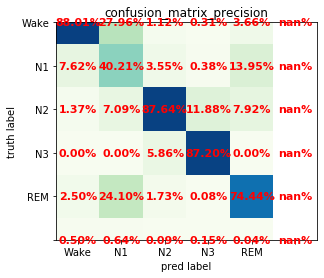

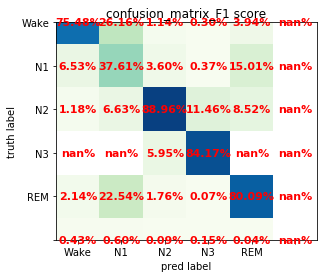

sensitivity
tensor([0.6607, 0.3533, 0.9032, 0.8134, 0.8666, 0.0000])
specificity
tensor([0.9890, 0.9481, 0.9000, 0.9802, 0.9172, 1.0000])
recall
tensor([0.6607, 0.3533, 0.9032, 0.8134, 0.8666, 0.0000])
precision
tensor([0.8801, 0.4021, 0.8764, 0.8720, 0.7444,    nan])
f1_score
tensor([0.7548, 0.3761, 0.8896, 0.8417, 0.8009,    nan])


In [36]:


def check_ResNet_custom_Confusion(test_signals_dir,annotations_dir,load_filename,save_path):
    n_categories = 6
    columns_format = ['Wake','N1','N2','N3','REM','None']

    dataset = search_npy_list(test_signals_dir)
    print(dataset)


    model = DeepSleepNet_Classification()

    cuda = torch.cuda.is_available()

    if cuda:
        print('can use CUDA!!!')
        model = model.cuda()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    test_total_loss = 0.0
    test_total_count = 0
    test_total_data = 0

    model.load_state_dict(torch.load(load_filename))

    confusion = torch.zeros(n_categories, n_categories)

    # 평가 모델 사용
    model.eval()
    for file_name in dataset:
        # get_signal_each_onechannel()
        batch_signal, batch_label = get_dataset_one_channel_norm_withoutCut(test_signal_dir,annotations_dir,file_name,
                                                                         use_noise=False,epsilon=0,noise_scale=0,
                                                                         preprocessing=True,norm_methods='Standard')
        #print(batch_signal.shape)
        batch_label_cpu = batch_label
        batch_label = torch.from_numpy(batch_label).long().to(device)
        batch_signal = signals_expand_torch_one_channel(batch_signal)
        
        with torch.no_grad():
            for index,batch_signal_each in enumerate(batch_signal):
                pred = model(batch_signal_each.reshape(1,1,-1))

                # acc
                _, predict = torch.max(pred, 1)
                check_count = (predict == batch_label[index]).sum().item()
                batch_label_one = batch_label[index].cpu().numpy()
                predict = predict.cpu().numpy()
                
                
                confusion[batch_label[index]][predict] += 1

                test_total_count += check_count
                test_total_data += len(pred)
    print(confusion)
    confusion_percent = torch.zeros(n_categories, n_categories)
    confusion_percent_recall = torch.zeros(n_categories, n_categories)
    sensitivity = torch.zeros(n_categories)
    specificity = torch.zeros(n_categories)
    recall = torch.zeros(n_categories)
    precision = torch.zeros(n_categories)
    f1_score = torch.zeros(n_categories)

    tp_fp = confusion.sum(dim=0)
    tp_fn = confusion.sum(dim=1)
    tn_fp = torch.zeros(n_categories)
    for i in range(6):
        for z in range(6):
            if z != i:
                tn_fp[i] += tp_fn[z]
    for index in range(n_categories):
        confusion_percent[index] = confusion[index] / tp_fp.float()
        confusion_percent_recall[index] = confusion[index] / tp_fn.float()
        tn = confusion.sum() - confusion.sum(dim=0)[index] - confusion.sum(dim=1)[index] + confusion[index][index]
        sensitivity[index] = confusion[index][index] / float(tp_fn[index])
        specificity[index] = tn / float(tn_fp[index])
        precision[index] = confusion[index][index] / float(tp_fp[index])

        recall[index] = sensitivity[index]

    f1_score = 2 * (precision * recall) / (precision + recall)
    test_total_loss /= len(dataset)
    test_accuracy = test_total_count / test_total_data * 100
    print('Total data accuracy : %d/%d -> %.4f%%' % (test_total_count, test_total_data, test_accuracy))
    stdout = ''
    for i in range(6):
        stdout += '%.2f '%(confusion_percent[i][i]*100)
    stdout += '\n'
    sys.stdout.write(stdout)
    confusion_percent_f1 = 2 * (confusion_percent * confusion_percent_recall) / (
                confusion_percent + confusion_percent_recall)
    stdout = ''
    for i in range(6):
        stdout += '%.2f '%(confusion_percent_f1[i][i]*100)
    stdout += '\n'
    sys.stdout.write(stdout)

    label = ['Wake', 'N1', 'N2', 'N3', 'REM']
    # Plot confusion matrix
    plt.imshow(confusion_percent, interpolation='none', cmap='GnBu')
    for (i, j), z in np.ndenumerate(confusion_percent):
        # print(i, j, z)
        plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='Red', fontSize=11, fontweight='bold')
    plt.title('confusion_matrix_precision')
    plt.xticks(np.arange(0, 6), label)
    plt.yticks(np.arange(0, 6), label)
    plt.xlabel("pred label")
    plt.ylabel("truth label")
    plt.savefig(save_path+'confusion_matrix_%d.png')
    plt.show()

    plt.imshow(confusion_percent_f1, interpolation='none', cmap='GnBu')
    for (i, j), z in np.ndenumerate(confusion_percent_f1):
        # print(i, j, z)
        plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='Red', fontSize=11, fontweight='bold')
    plt.title('confusion_matrix_F1 score')
    plt.xticks(np.arange(0, 6), label)
    plt.yticks(np.arange(0, 6), label)
    plt.xlabel("pred label")
    plt.ylabel("truth label")
    plt.savefig(save_path+'confusion_matrix_f1score_%d.png')
    plt.show()

    print('sensitivity')
    print(sensitivity)
    print('specificity')
    print(specificity)
    print('recall')
    print(recall)
    print('precision')
    print(precision)
    print('f1_score')
    print(f1_score)

def make_result_channel_new():
    load_filename = './train.pth'
    logging_filename = './logging.txt'
    save_path = './result/'
    os.makedirs(save_path,exist_ok=True)
    test_signals_dir = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/test/'
    annotations_dir = 'D:/dataset/data_2013/origin_npy/annotations/remove_wake/'
    check_ResNet_custom_Confusion(test_signals_dir,annotations_dir,load_filename,save_path)
make_result_channel_new()